NASA POWER 気象データ × LSTM 時系列予測モデル/NASA POWER meteorological data × LSTM time-series prediction model

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/test/

Mounted at /content/drive
/content/drive/MyDrive/test


Received JSON data:
{
    "type": "Feature",
    "geometry": {
        "type": "Point",
        "coordinates": [
            139.7,
            35.7,
            38.67
        ]
    },
    "properties": {
        "parameter": {
            "T2M": {
                "20180101": 4.88,
                "20180102": 4.54,
                "20180103": 3.23,
                "20180104": 2.83,
                "20180105": 2.08,
                "20180106": 3.78,
                "20180107": 4.8,
                "20180108": 7.7,
                "20180109": 10.32,
                "20180110": 5.53,
                "20180111": 3.77,
                "20180112": 1.95,
                "20180113": 2.57,
                "20180114": 2.49,
                "20180115": 5.87,
                "20180116": 7.36,
                "20180117": 11.96,
                "20180118": 8.45,
                "20180119": 6.28,
                "20180120": 5.74,
                "20180121": 6.21,
                "20180122": 2.84,
   

,temp
date,
2018-01-01,4.88
2018-01-02,4.54
2018-01-03,3.23
2018-01-04,2.83
2018-01-05,2.08


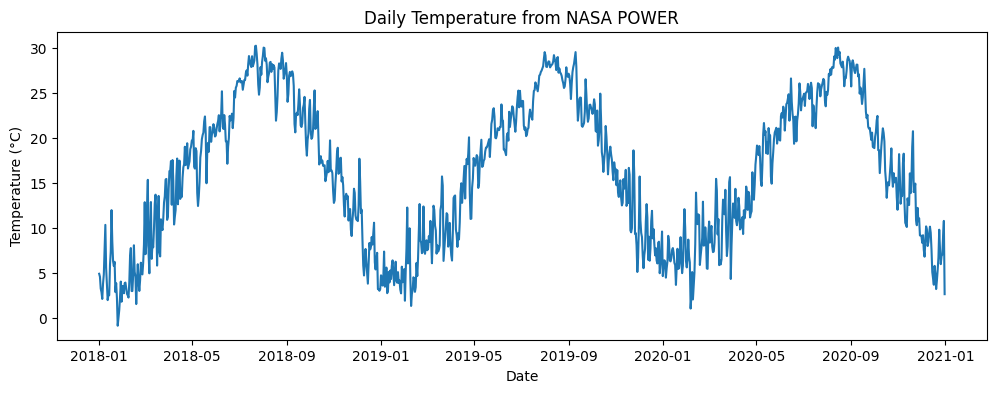

X shape: (1066, 30, 1)
y shape: (1066, 1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,009 (74.25 KB)

 Trainable params: 19,009 (74.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 0.1161 - val_loss: 0.0097
Epoch 2/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0117 - val_loss: 0.0071
Epoch 3/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0064 - val_loss: 0.0067
Epoch 4/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0056 - val_loss: 0.0064
Epoch 5/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0048 - val_loss: 0.0064
Epoch 6/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0053 - val_loss: 0.0064
Epoch 7/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0053 - val_loss: 0.0063
Epoch 8/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0049 - val_loss: 0.0063
Epoch 9/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0054 - val_loss: 0.0063
Epoch 10/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0050 - val_loss: 0.0063
Epoch 11/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0051 - val_loss: 0.0063
Epoch 12/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0

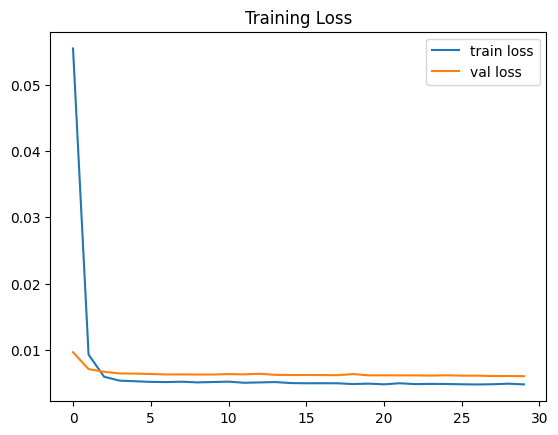

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


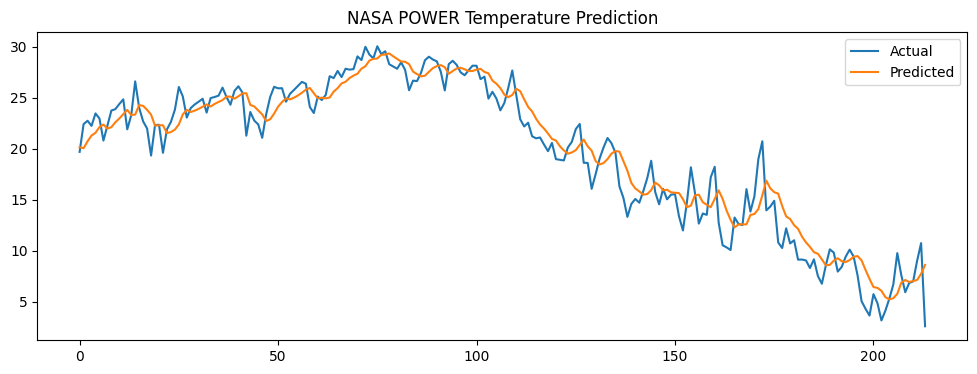

We built a temperature prediction model for the following day using NASA POWER data.


In [2]:
# 1. ライブラリ準備/Setting up the library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import json

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

# 2. NASA POWER API からデータ取得/Retrieve data from the NASA POWER API
# 例：東京（緯度 35.7, 経度 139.7）
LAT = 35.7
LON = 139.7

url = (
    f"https://power.larc.nasa.gov/api/temporal/daily/point"
    f"?parameters=T2M&start=20180101&end=20201231"
    f"&latitude={LAT}&longitude={LON}&format=JSON&community=ag" # Added community=ag
)

response = requests.get(url)
data_json = response.json()

# Print the JSON data to inspect its structure
print("Received JSON data:")
print(json.dumps(data_json, indent=4))


# 日次データの抽出/Extraction of daily data
# Check if 'properties' and 'parameter' keys exist before accessing
if 'properties' in data_json and 'parameter' in data_json['properties'] and 'T2M' in data_json['properties']['parameter']:
    daily_data = data_json["properties"]["parameter"]["T2M"]

    # データフレーム化/create a DataFrame from
    df = pd.DataFrame(list(daily_data.items()), columns=["date", "temp"])
    df["date"] = pd.to_datetime(df["date"], format='%Y%m%d') # Corrected date format
    df = df.sort_values("date")
    df.set_index("date", inplace=True)

    # 最初の5行確認/Check the first five lines
    print("データ先頭/Data header：")
    display(df.head())

    # 3. 可視化/Visualization
    plt.figure(figsize=(12,4))
    plt.plot(df.index, df["temp"])
    plt.title("Daily Temperature from NASA POWER")
    plt.xlabel("Date")
    plt.ylabel("Temperature (°C)")
    plt.show()

    # 4. 前処理（Min-Max 正規化）/Preprocessing (Min-Max Normalization)
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(df[["temp"]])

    # 時系列データのウィンドウ作成（過去 30 日 → 次の日の気温予測）/Creating a window for time-series data (past 30 days → next day's temperature forecast)
    def make_dataset(data, window=30):
        X, y = [], []
        for i in range(len(data) - window):
            X.append(data[i:i+window]) # Corrected window size
            y.append(data[i+window])
        return np.array(X), np.array(y)

    WINDOW = 30
    X, y = make_dataset(scaled, WINDOW)

    print("X shape:", X.shape)
    print("y shape:", y.shape)

    # 学習用 / テスト用に分割（80% / 20%）/Split for learning / testing (80% / 20%)
    train_size = int(len(X) * 0.8)

    X_train = X[:train_size]
    y_train = y[:train_size]

    X_test = X[train_size:]
    y_test = y[train_size:]

    # 5. LSTM モデル構築/LSTM model construction
    model = Sequential([
        LSTM(64, activation="tanh", return_sequences=False, input_shape=(WINDOW, 1)),
        Dense(32, activation="relu"),
        Dense(1)
    ])

    model.compile(optimizer="adam", loss="mse")
    model.summary()

    # 6. モデル学習/Model training
    es = EarlyStopping(patience=5, restore_best_weights=True)

    history = model.fit(
        X_train, y_train,
        epochs=30,
        batch_size=32,
        validation_split=0.2,
        callbacks=[es],
        verbose=1
    )

    # 学習過程の可視化/Visualization of the learning process
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='val loss')
    plt.title("Training Loss")
    plt.legend()
    plt.show()

    # 7. 予測/Prediction
    pred = model.predict(X_test)

    # スケールを元に戻す/Reset the scale
    pred_inverse = scaler.inverse_transform(pred)
    y_test_inverse = scaler.inverse_transform(y_test)

    # 8. 結果の比較プロット/Comparison plot of results
    plt.figure(figsize=(12,4))
    plt.plot(y_test_inverse, label="Actual")
    plt.plot(pred_inverse, label="Predicted")
    plt.legend()
    plt.title("NASA POWER Temperature Prediction")
    plt.show()

    print("We built a temperature prediction model for the following day using NASA POWER data.")

else:
    print("Error: 'properties', 'parameter', or 'T2M' key not found in the received JSON data.")
    print("Please check the API request parameters or the API response structure.")